In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
matplotlib.rcParams.update({'font.size': 18})

INFO: Using pytorch backend
/tmp/ipykernel_2807954/583152811.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_pickle("data/16Mnist_AE")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)

In [3]:
model_src = "lightning_logs/E16VAE_3_wodo/version_0"
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    f"{model_src}/checkpoints/last.ckpt"
)

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  64
[100, 512, 512, 100]
[100, 512, 512, 100]
[100, 512, 512, 100]
[100, 512, 512, 100]


In [4]:
torch.set_grad_enabled(False)

torch.Size([230000, 256])
torch.Size([40000, 256])
tensor(0.2219)
tensor(0.3482)
encoding...
reconstructing...
sampling...
tensor([0.2018, 0.0670, 0.0612, 0.0683, 0.1215, 0.1739, 0.1012, 0.0477, 0.0874,
        0.0979, 0.0763, 0.1185, 0.1800, 0.0673, 0.1257, 0.1551, 0.0752, 0.1262,
        0.2913, 0.1455])
mean_res_true tensor(0.1269)
main detail standard deviation:  tensor(0.9680)
2nd detail standard deviation:  tensor(0.9830)


{}

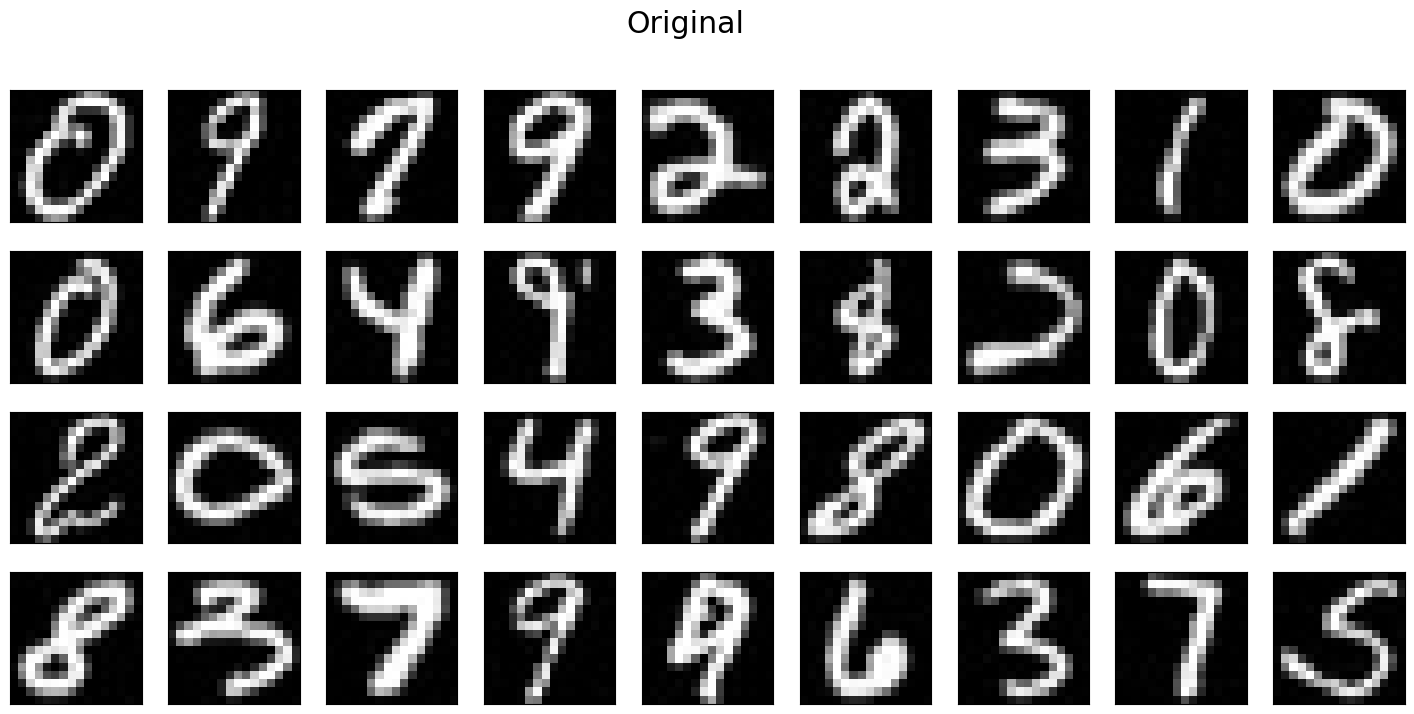

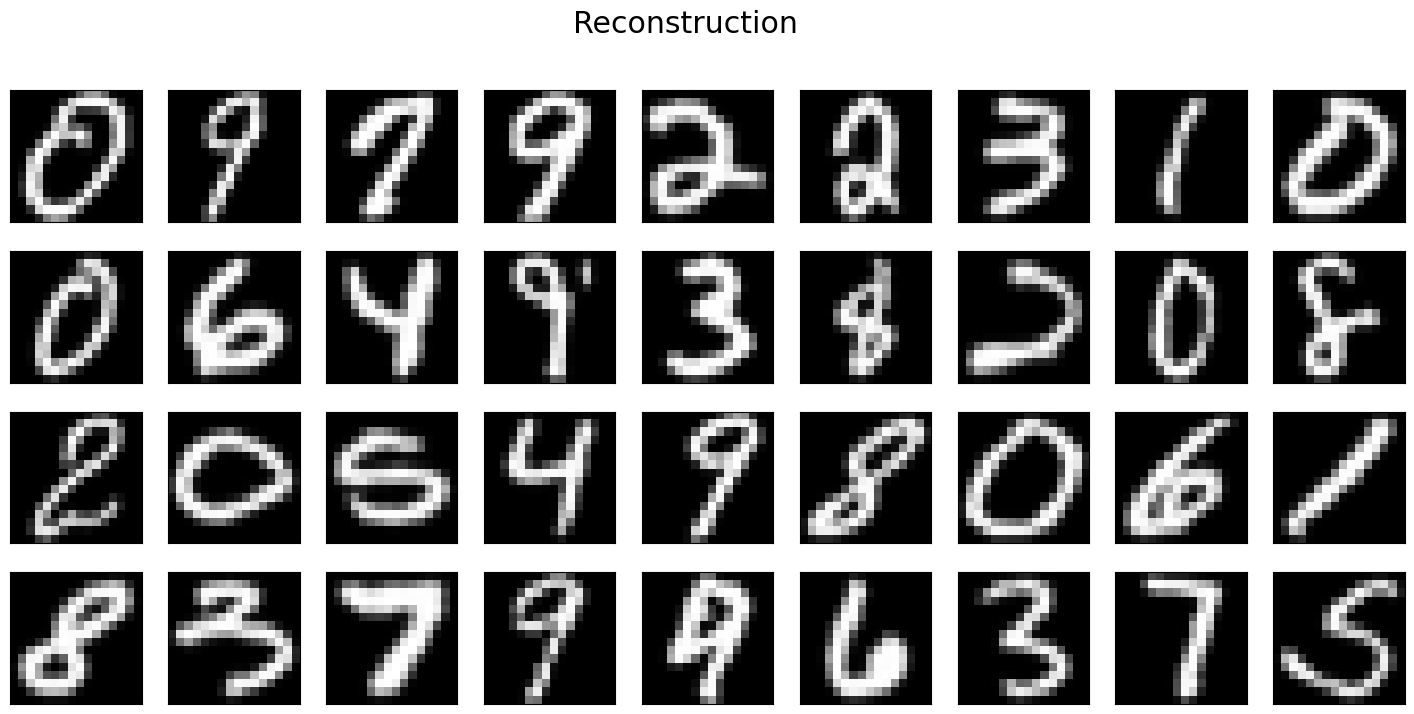

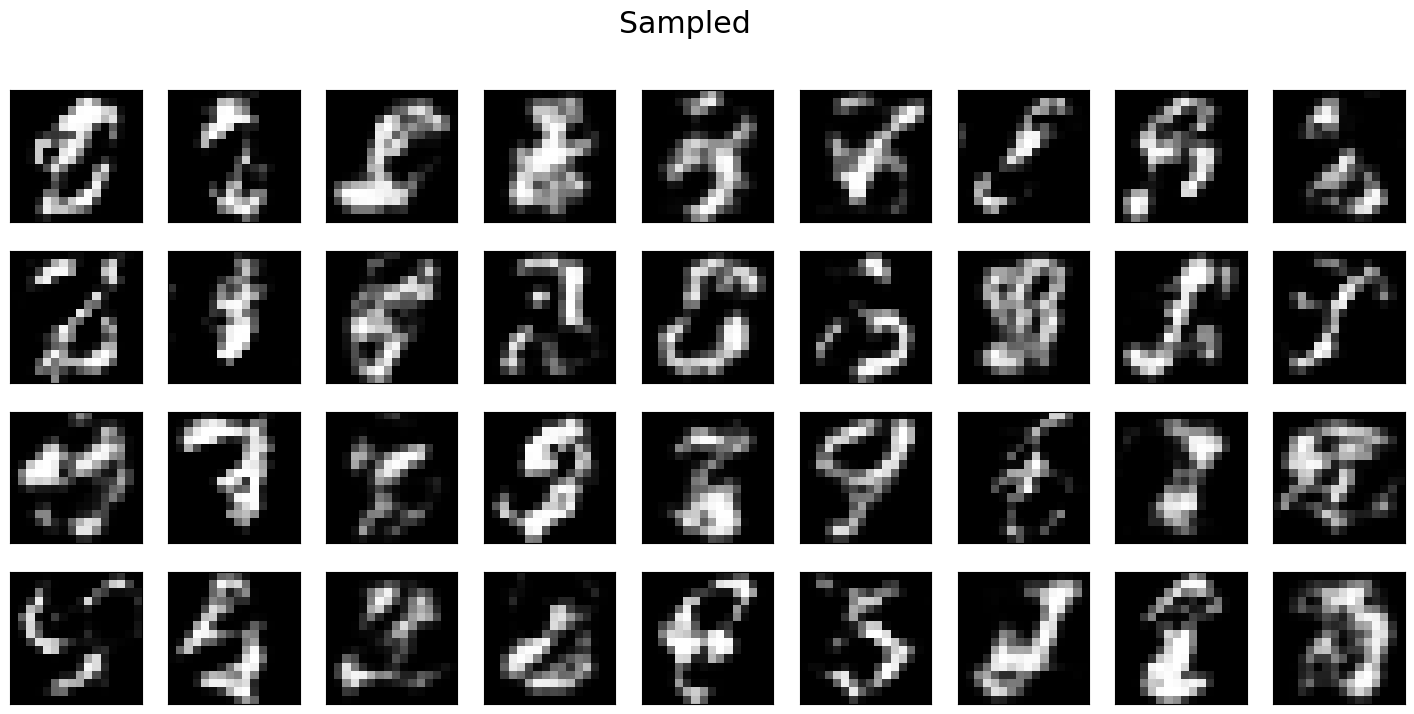

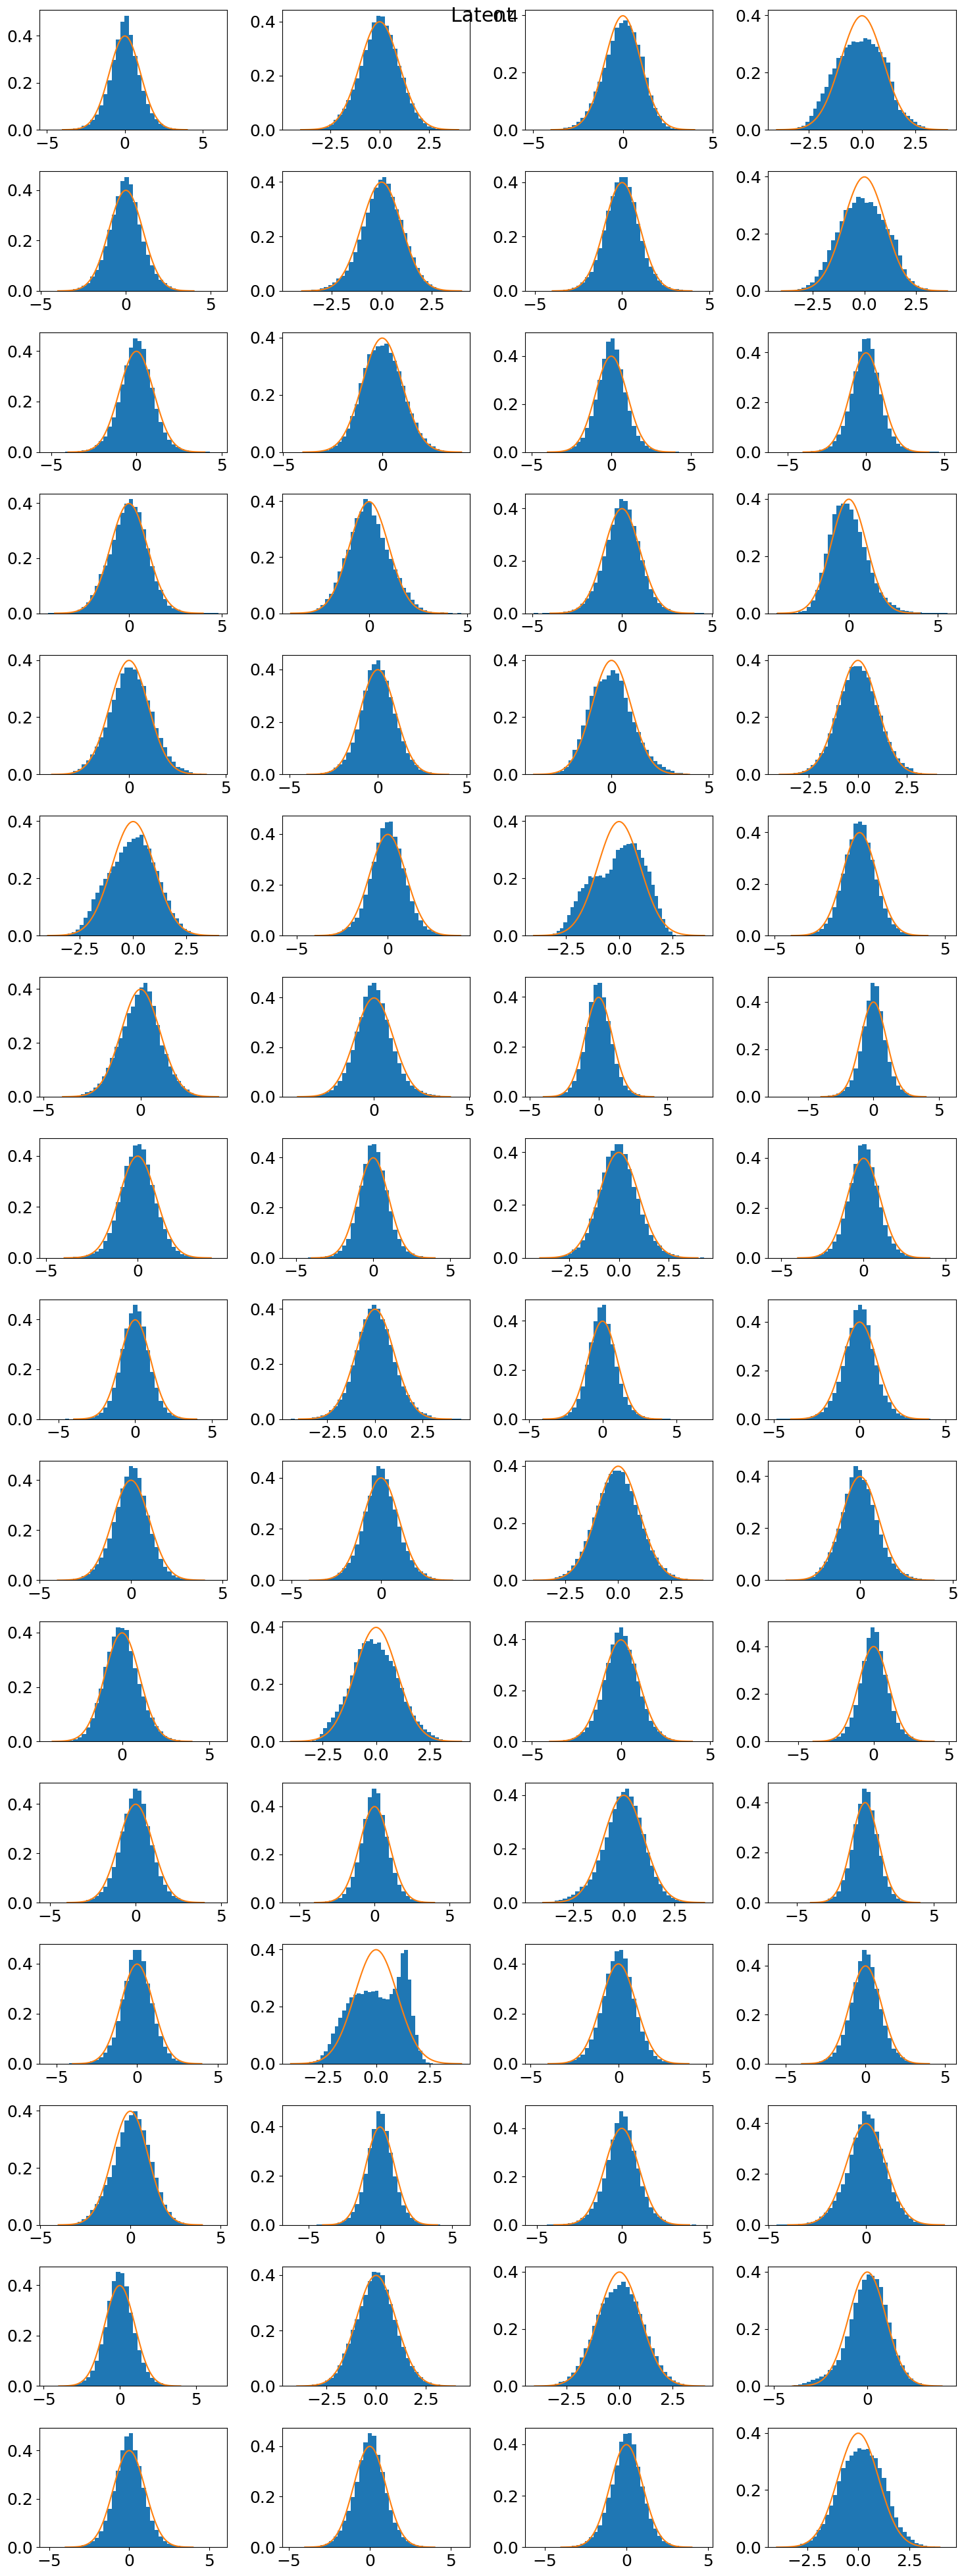

In [7]:
save = True
plot_dir = "emnist/VAE"
from pathlib import Path
import shutil
if save:
    Path(f"plots/{plot_dir}/runfile").mkdir(parents=True, exist_ok=True)
    shutil.copytree(model_src, f"plots/{plot_dir}/runfile", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)
plot_mnist(model)

In [5]:
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    true_test_batch = model2plt.test_data[:]
    print(true_test_batch[0].size())
    
    test_conditioned = model2plt.apply_conditions(true_test_batch)
    true_test_c = test_conditioned.condition
    true_test_samples = test_conditioned.x_noisy
    
    #computing...
    print("encoding...")

    batch_size = model2plt.hparams.batch_size
    true_test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_test_samples.split(batch_size), true_test_c.split(batch_size))
    ])
    
    print("reconstructing...")
    true_reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(true_test_z.split(batch_size), true_test_c.split(batch_size))
    ])

    print("sampling...")
    #x_sampled = model2plt.sample((test_z[:100].shape[0],))
    z_sampled = torch.randn_like(true_test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), true_test_c.split(batch_size))
    ])

    residual_true = torch.abs(true_reconstruction - true_test_samples)
    res_true_summed = torch.sum((residual_true)**2, dim=1)
    print(res_true_summed[:20])
    print("mean_res_true", torch.mean(res_true_summed))
    
    #plotting...
    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18, 8))
    for i in range(4):
        for j in range(9):
            axes[i][j].imshow((true_test_samples[i*9 +j]).cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Original")
    if save:
        plt.savefig(f"plots/{plot_dir}/orig.png", bbox_inches='tight')

    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18, 8))
    for i in range(4):
        for j in range(9):
            axes[i][j].imshow(true_reconstruction[i*9 +j].cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/recon.png", bbox_inches='tight')

    
    fig, axes = plt.subplots(nrows=4, ncols=9, figsize=(18, 8))
    for i in range(4):
        for j in range(9):
            axes[i][j].imshow(x_sampled[i*9 +j].cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Sampled")
    if save:
        plt.savefig(f"plots/{plot_dir}/sampled.png", bbox_inches='tight')

    nrows = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(15, nrows*2.5))
    a = np.linspace(-4,4,100)
    for i in range(nrows):
        for j in range(4):
            axes[i][j].hist(true_test_z[:,i*4+j], bins=40, label="Samples", density=True)
            axes[i][j].plot(a, normal(a))
    fig.suptitle("Latent")
    fig.tight_layout()
    if save:
        plt.savefig(f"plots/{plot_dir}/latent.png", bbox_inches='tight')

    return data

In [6]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)